In [1]:
import dash, math, datetime as dt, pandas as pd
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc, html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template
import plotly.io as pio

%load_ext autoreload
%autoreload 2
import figures, main_etl, extract_data, transform_data

## Epics por Template

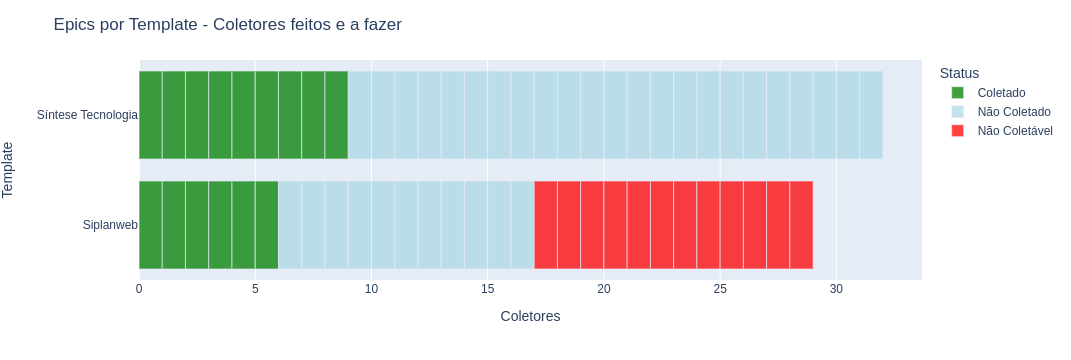

In [4]:
template_df = pd.read_csv("data/coletas_por_template.csv")
figures.plot_status_template(template_df, title='Epics por Template - Coletores feitos e a fazer', 
                             y_column='Template', x_column='Coletor', hue="Status", showlegend=True)

In [64]:
%%time
from github import Github
from zenhub import Zenhub

git_token='...'
zh_token='...'
zh = Zenhub(zh_token)
g = Github(git_token)
repo_id='357557193'
creators = ['carbo6ufmg', 'RitaRez', 'asafeclemente', 'CinthiaS', 'isabel-elise', 'arthurnader']
info_issues = {'title': [], 'number': [], 'created_at': [], 'closed_at': [], 'labels' : [], 'state': [] }
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

info_issues, df, _, _ = main_etl.main_tranform_data(repo_C01, creators, info_issues)
_, epics_id = transform_data.count_issues_epic(df, zh, repo_F01, repo_id)

CPU times: user 12.2 s, sys: 48.2 ms, total: 12.2 s
Wall time: 2min 7s


In [65]:
%%time 
epics_info, count_epics_month = transform_data.summarize_epics(epics_id, repo_F01, info_issues)
epics_info.to_csv("data/epics.csv", index=False) 
epics_info

CPU times: user 667 ms, sys: 16 ms, total: 683 ms
Wall time: 22.9 s


,title,number,created_at,closed_at,labels,state
1004,Coletor para o template ABO,1143,2022-01-05 13:07:41,2022-01-05 13:08:55,[],closed
1827,Coletor para o template da PT (45) (Licitações),96,2021-11-19 10:37:23,2022-01-20 14:51:32,"[Label(name=""Realização F01""), Label(name=""Epi...",closed
1829,Coletor para o template ABO - Licitações,187,2022-01-17 13:34:01,NaT,"[Label(name=""Epic""), Label(name=""tag-Licitação...",open
1830,Coletor para o template Siplanweb - Acesso à I...,478,2022-04-06 11:37:32,NaT,"[Label(name=""Realização F01""), Label(name=""Epi...",open
1831,Coletor para o template Portal Cidadão - Despesas,112,2021-12-14 17:16:37,NaT,"[Label(name=""Epic""), Label(name=""tag-Despesas"")]",open
...,...,...,...,...,...,...
1911,Coletor para o template Síntese Tecnologia e I...,378,2022-03-14 12:16:35,2022-03-15 17:57:28,"[Label(name=""Realização F01""), Label(name=""Epi...",closed
1912,Coletor para o template Síntese Tecnologia e I...,379,2022-03-14 13:01:04,2022-03-17 16:47:17,"[Label(name=""Realização F01""), Label(name=""Epi...",closed
1913,Coletor para o template Siplanweb - Despesas -...,380,2022-03-18 00:56:56,2022-03-31 13:22:48,"[Label(name=""Realização F01""), Label(name=""Epi...",closed
1914,Coletor para o template Siplanweb - Despesas -...,377,2022-03-10 19:05:22,NaT,"[Label(name=""Realização F01""), Label(name=""Epi...",open


In [4]:
epics_info[3:4].values

array([['Coletor para o template Siplanweb - Acesso à Informação - Requisitos Exigidos',
        478, Timestamp('2022-04-06 11:37:32'), NaT,
        list([Label(name="Realização F01"), Label(name="Epic"), Label(name="template-Siplanweb"), Label(name="tag-Acesso à Informação"), Label(name="subtag-Requisitos Exigidos")]),
        'open']], dtype=object)

In [124]:
import re
import numpy as np

def find_label(item_labels, target_label):    
    
    item_labels = str(item_labels)
    found = re.match(r'.*"' + target_label + r'-([^"]*?)"', item_labels)    
    
    if found: 
        return found.group(1)
    
    return None

def process_epics(df, target_labels=['template', 'tag', 'subtag'], remove_orig_col=True):
    
    for target_label in target_labels:
        df[target_label] = df.apply(lambda x: find_label(x['labels'], target_label), axis=1)
        
    df.loc[df.labels.astype(str).str.contains('não-localizado'), 'state'] = 'Não localizado'
    df.loc[df.state == 'closed', 'state'] = 'Coletado'
    df.loc[df.state == 'open', 'state'] = 'Com epic criada'
    
    df = df.rename(columns={'number':'git_issue'})
    df['aux'] = 1 #TODO
    
    if remove_orig_col:
        df = df.drop(columns='labels')
    
    return df

epics = process_epics(epics_info)
epics.to_csv("data/epics.csv", index=False) 
epics

,title,git_issue,created_at,closed_at,state,template,tag,subtag,aux
1004,Coletor para o template ABO,1143,2022-01-05 13:07:41,2022-01-05 13:08:55,Coletado,NaN,NaN,NaN,1
1827,Coletor para o template da PT (45) (Licitações),96,2021-11-19 10:37:23,2022-01-20 14:51:32,Coletado,PT,Licitação,NaN,1
1829,Coletor para o template ABO - Licitações,187,2022-01-17 13:34:01,NaT,Com epic criada,ABO,Licitação,NaN,1
1830,Coletor para o template Siplanweb - Acesso à I...,478,2022-04-06 11:37:32,NaT,Com epic criada,Siplanweb,Acesso à Informação,Requisitos Exigidos,1
1831,Coletor para o template Portal Cidadão - Despesas,112,2021-12-14 17:16:37,NaT,Com epic criada,NaN,Despesas,NaN,1
...,...,...,...,...,...,...,...,...,...
1911,Coletor para o template Síntese Tecnologia e I...,378,2022-03-14 12:16:35,2022-03-15 17:57:28,Coletado,Síntese tecnologia informatica,Despesas,Relatórios,1
1912,Coletor para o template Síntese Tecnologia e I...,379,2022-03-14 13:01:04,2022-03-17 16:47:17,Coletado,Síntese tecnologia informatica,Despesas,Relatórios,1
1913,Coletor para o template Siplanweb - Despesas -...,380,2022-03-18 00:56:56,2022-03-31 13:22:48,Coletado,Siplanweb,Despesas,Leis Orçamentárias,1
1914,Coletor para o template Siplanweb - Despesas -...,377,2022-03-10 19:05:22,NaT,Com epic criada,Siplanweb,Despesas,Relatórios,1


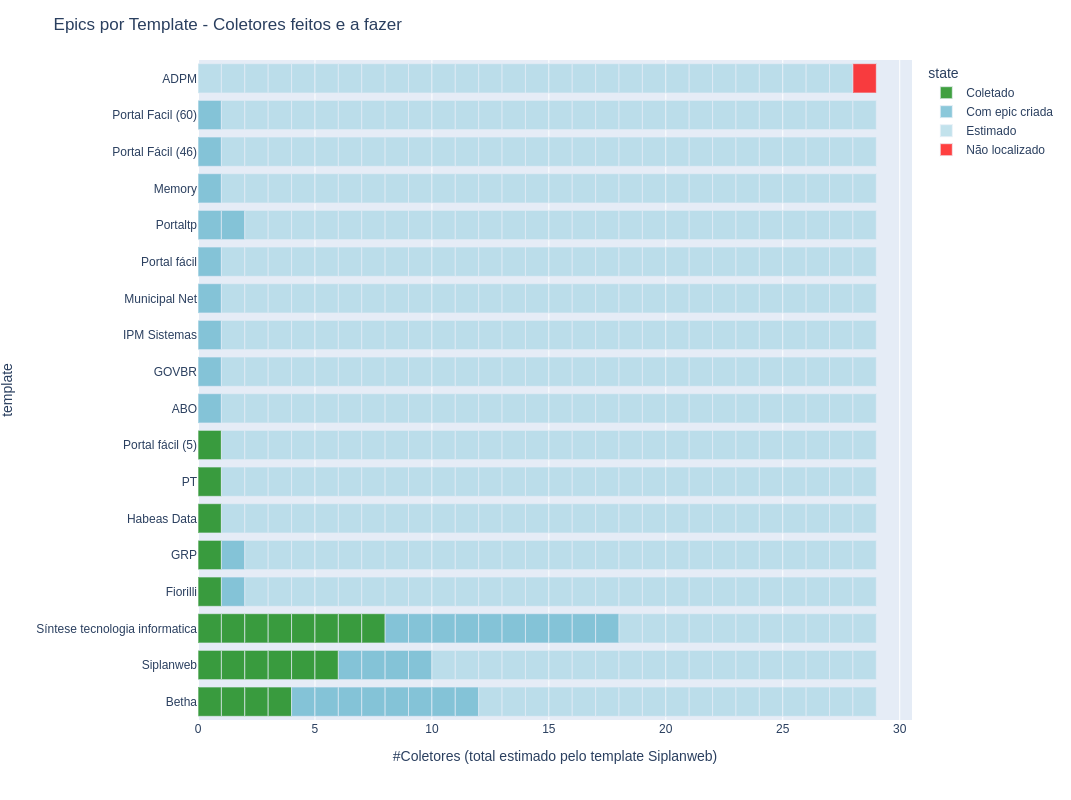

In [114]:
import plotly
import plotly.graph_objects as go 
import plotly.figure_factory as ff
import plotly.express as px

def plot_status_template(df, title, y_column, x_column, hue, showlegend=True):

    #TODO adding estimates and unavailable
    total = 29 # Siplanweb
    templates = df['template'].dropna().unique()
    
    for template in templates:
        created =  df.groupby('template').count()['title'][template]
        missing = total - created
        for i in range(missing):
            df = df.append({'template':template, 'state':'Estimado', 'aux':1}, ignore_index=True)    
        
    df = df.sort_values(by=[hue, x_column])

    fig =  px.bar(df, y=y_column, x="aux", orientation="h", color=hue, height=800, width=900,
        color_discrete_map={"Coletado":"green", "Com epic criada":"#64b5cd", 'Estimado':'lightblue', "Não localizado":"red"}, 
        labels={"aux":"#Coletores (total estimado pelo template Siplanweb)"} )    
    fig.update_layout(title=title) 
    fig.update_traces(opacity=0.75, showlegend=showlegend)

    # Seaborn colors  
    # ['#4c72b0', '#dd8452', '#55a868', '#c44e52', '#8172b3', '#937860', '#da8bc3', '#8c8c8c', '#ccb974', '#64b5cd']
    return fig

epics_df = pd.read_csv("data/epics.csv")
plot_status_template(epics_df, title='Epics por Template - Coletores feitos e a fazer', 
                             y_column='template', x_column='title', hue="state", showlegend=True)

# TODO completar com issues estimadas (aumentar total)
# TODO completar issues sem labels (branco)


# BKP

In [1]:
import os
import spacy
from github import Github
from zenhub import Zenhub
import pandas as pd
import numpy as np

import plotly.graph_objects as go 

nlp = spacy.load('pt_core_news_sm')

repo_id='357557193'

In [2]:
import pickle
import dash
from dash.dependencies import Input, Output, State, ClientsideFunction
from dash import dcc
from dash import html
import dash_bootstrap_components as dbc
from dash_bootstrap_templates import load_figure_template

import plotly
import plotly.figure_factory as ff
import plotly.io as pio

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pd.options.mode.chained_assignment = None 

In [148]:
import extract_data
import transform_data
import figures

In [251]:
%load_ext autoreload
%autoreload 2

import main_etl
import app
import figures
import extract_data
import transform_data
import pandas as pd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
from github import Github
from zenhub import Zenhub

In [6]:
repo_id_f01='357557193'
git_token=<TOKEN>
zh_token=<TOKEN>

In [7]:
zh = Zenhub(zh_token)
g = Github(git_token)
    
repo_C01 = g.get_repo("MPMG-DCC-UFMG/C01")
repo_F01 = g.get_repo("MPMG-DCC-UFMG/F01")

In [355]:
main_etl.job()

In [205]:
def get_info_epics_by_id(epics_id, filter_data=False):
    
    data = {'title': [], 'id':[] , 'tag':[], 'template': [], 'status': []}

    for epic_id in epics_id:
    
        issue = repo_F01.get_issue(epic_id)
        labels = issue.labels
        labels = [i.name for i in labels]
    
        if 'generalization test' in labels or filter_data:

            data['title'].append(issue.title)
            data['id'].append(epic_id)
            data['tag'].append(extract_data.get_specific_labels(labels, pattern='tag'))
            data['template'].append(extract_data.get_specific_labels(labels, pattern='template'))
            data['status'].append(issue.state)
        
    df = pd.DataFrame(data)
    
    return df

In [184]:
def get_info_issues_by_id(ids):
    
    data = {'title': [], 'id':[], 'status': [], 'created_at':[], 'closed_at':[]}
    
    for issue_id in ids:
    
        issue = repo_F01.get_issue(issue_id)
    
        data['title'].append(issue.title)
        data['id'].append(issue_id)
        data['status'].append(issue.state)
        data['created_at'].append(issue.created_at)
        data['closed_at'].append(issue.closed_at)
        
    df = pd.DataFrame(data)
    
    return df

In [253]:
def main_job2():
    epics_id = extract_data.get_epics_ids(zh, repo_id_f01)
    epics_df = extract_data.get_info_filtered_issues(epics_id, repo_F01)

    epics_id_dev = list(epics_df['id'])
    issues_data = extract_data.get_data_epics(zh, epics_id_dev, repo_id_f01)
    epics_info = extract_data.get_epics_info(repo_F01, issues_data)
    epics_info_df = pd.DataFrame(epics_info).T.reset_index()

    exploded_df = epics_info_df.explode('issues').reset_index(drop=True)

    exploded_df = exploded_df.loc[~exploded_df['issues'].isna()]
    issues_id = exploded_df['issues'].tolist()

    info_issues_dev = extract_data.get_info_issues_by_id(issues_id, repo_F01)

    info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
    info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

    info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
    info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

    closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
    closed_df.drop('1/1970', axis = 1,inplace=True)

    open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

    columns_name = transform_data.sort_columns(open_df)
    open_df = open_df[columns_name]

    columns_name = transform_data.sort_columns(closed_df)
    closed_df = closed_df[columns_name]

    count_month_dev = transform_data.count_by_month(open_df, closed_df)

    df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
    df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
    df = df.sort_values('closed', ascending=False)

    count_month_dev.to_csv("data/count_month_dev.csv", index=False)
    open_df.to_csv("data/open_df_dev.csv", index=False)
    closed_df.to_csv("data/closed_df_dev.csv", index=False)
    df.to_csv("data/coletas_tag_dev.csv", index=False)

In [254]:
main_job2()

In [211]:
issues_id = exploded_df['issues'].tolist()

In [185]:
info_issues_dev = get_info_issues_by_id(issues_id)

In [256]:
info_issues_dev['week'] =  pd.to_datetime(info_issues_dev['closed_at']).dt.strftime('%W')
week_status = transform_data.count_by_week(info_issues_dev, column_to_group='week', time_column='closed_at')

In [259]:
week_status.to_csv("data/week_status_dev.csv", index=False)

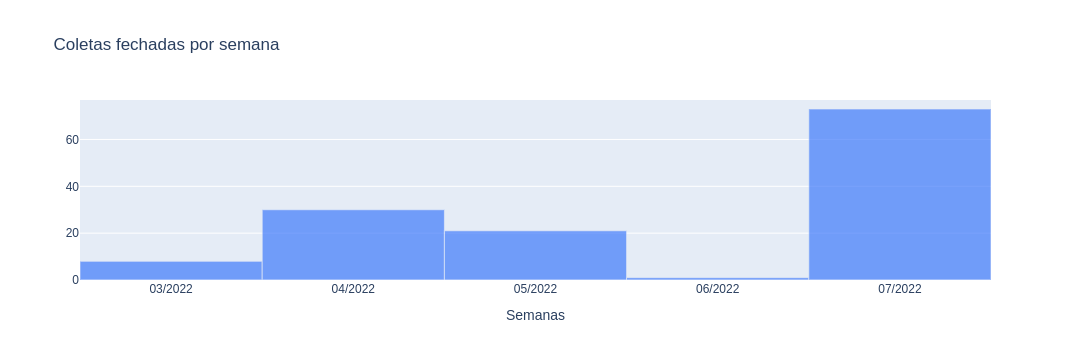

In [258]:
figures.plot_status_week(
        week_status, y_column='closed_at', x_column='week',
        title='Coletas fechadas por semana', xaxis_title_text='Semanas')

In [187]:
info_issues_dev.to_csv("data/info_issues_dev.csv", index=False)
info_issues_dev = pd.read_csv("data/info_issues_dev.csv")

In [188]:
info_issues_dev['closed_at'] = info_issues_dev['closed_at'].fillna(0)
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='closed_at', status='closed')
info_issues_dev = transform_data.format_date(info_issues_dev, time_column='created_at', status='created')

In [189]:
closed_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_closed', aggfunc='count').fillna(0).reset_index()
closed_df.drop('1/1970', axis = 1,inplace=True)

open_df = info_issues_dev.pivot_table(values='title', index=['id'], columns='format_date_created', aggfunc='count').fillna(0).reset_index()

In [190]:
columns_name = transform_data.sort_columns(open_df)
open_df = open_df[columns_name]

columns_name = transform_data.sort_columns(closed_df)
closed_df = closed_df[columns_name]

In [231]:
count_month_dev = transform_data.count_by_month(open_df, closed_df)

In [192]:
x = open_df.columns[1:].tolist()
z = open_df.columns[1:]
y = 'municipio'

closed_colum='closed'
open_colum='open'

fig1 = figures.plot_status_mes(
        count_month, x_column=x, name1='Issues de generalização abertas', name2="Issues de generalização fechadas",
        y1_column=open_colum, y2_column=closed_colum, title='Generalizações por mês')

In [232]:
count_month_dev.to_csv("data/count_month_dev.csv", index=False)

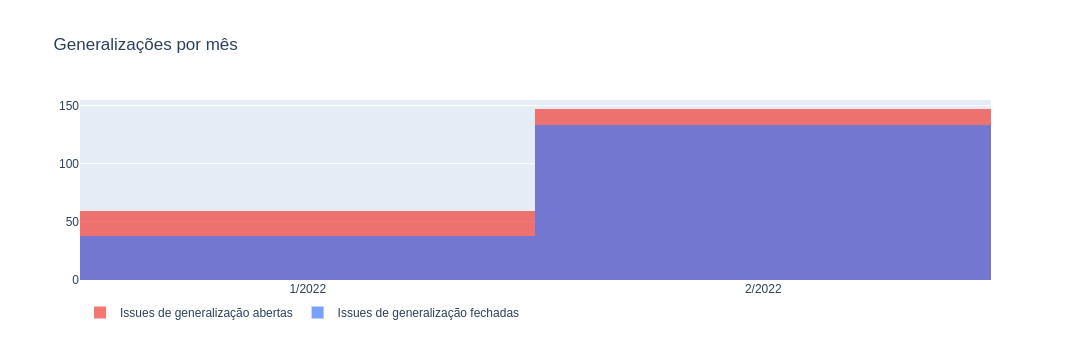

In [193]:
fig1.show()

In [239]:
open_df.to_csv("data/open_df_dev.csv", index=False)
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [240]:
closed_df.to_csv("data/closed_df_dev.csv", index=False)

In [223]:
df = info_issues_dev.merge(exploded_df, left_on='id', right_on='issues')
df = df.groupby(['template','tag', 'status'])['status'].count().unstack().reset_index().fillna(0)
df = df.sort_values('closed', ascending=False)

In [233]:
df.to_csv("data/coletas_tag_dev.csv", index=False)

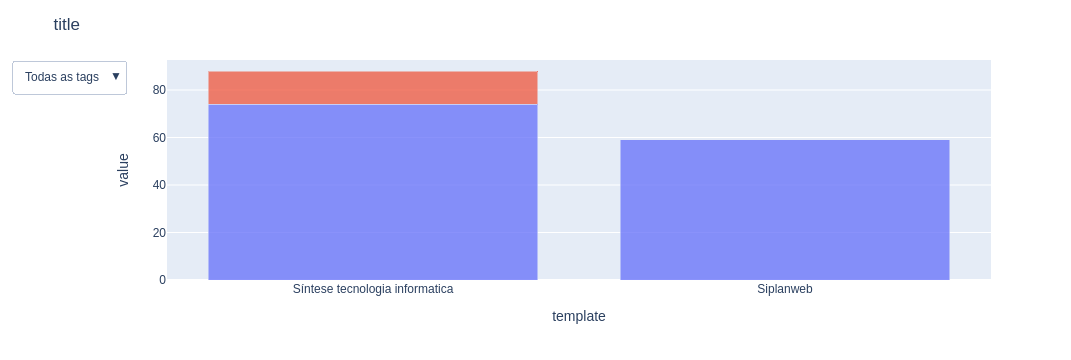

In [228]:
fig =  px.bar(df, x="template", y=["closed", "open"])

fig.update_layout(barmode='stack')

tag_list = pd.unique(df['tag']).tolist() 
buttons = []
    
buttons.append(dict(method = "restyle",
                args = [{'y': [df['closed'], df['open']], 'x': [df['template']]}],
                label = "Todas as tags"))
    
for tag in tag_list:
    aux = df.loc[df['tag'] == tag]
    
    buttons.append(dict(method = "restyle",
                args = [{'y': [aux['closed'], aux['open']], 'x':[aux['template']]},],
                label = tag))
    
fig.update_layout(autosize=True, title='title',
                  updatemenus=[dict(active=0,
                                    buttons=buttons)
                              ]) 

fig.update_traces(opacity=0.75, showlegend=False)

In [241]:
fig1, fig2 = figures.create_figures_dev()

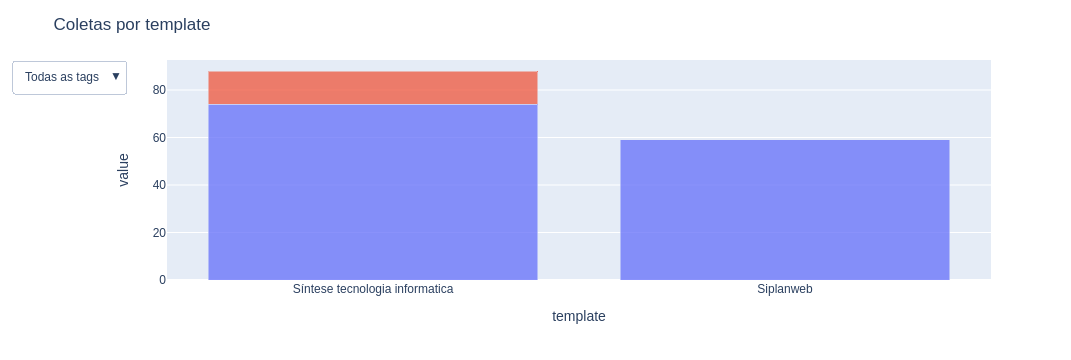

In [243]:
fig2.show()

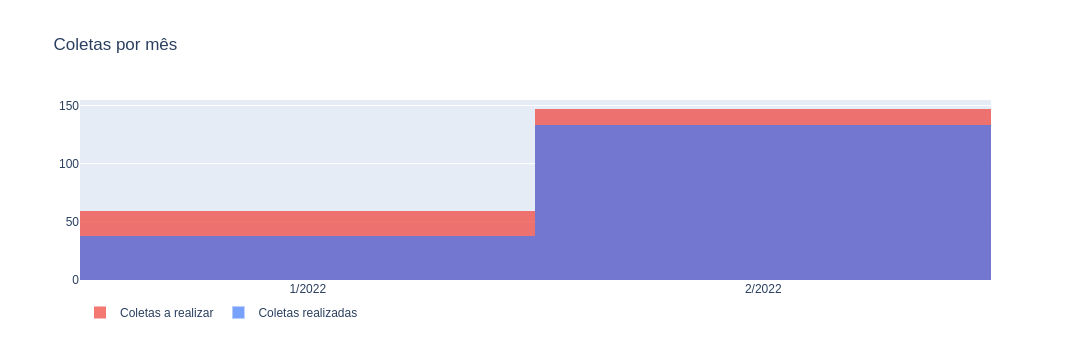

In [242]:
fig1.show()